In [62]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from pprint import pprint

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score,balanced_accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h1 style="background-color:navy;">1) Objectives for the project (NEWS CLASSIFICATION)</h1>

- In this project, I want to predict the category of a news article (text).
- The data used here is scraped from DW News portal (code in task2_data_acquistion.ipynb).
- The data contains actual news article and its category as specified by DW News.
- The primary goal of the project is to:
    - Create two classifier models which can predict the category of a text article.
    - Evaluate and compare their performances.
- Steps:
    - Load the dataset which was created by scraping (dw_articles.csv)
    - Clean the text data
    - Split the data into train, validation and test datasets.
    - Build a fined-tuned bert transformer classifier based on pretrained bert transfomer (Transfer Learning) without our own scraped dataset
    - Train and evaluate the transformer based classifier.
    - Create Term Frequency - Inverse Document Frequency vectors so that they would be used as input data for Support Vector classifier.
    - Train and evaluate the default SVC model on training data and test data respectively.
    - Use GridSearchCV to cross validate svm classifier
    - Use best model returned from cross validation to evaluate the test data.
    - Compare the performance of all built classifiers.
    - Provide conclusion and recommendations.

<h1 style="background-color:navy;">2) Data Loading and Exploration</h1>

In [2]:
# load the scraped dw articles file
df = pd.read_csv('dw_articles.csv')
df.head()

,url,category,title,text,target_category
0,https://www.dw.com/en/germany-undeterred-by-gl...,POLITICS,Germany undeterred by global turmoil — Scholz ...,"In his New Year's message, German Chancellor O...",Politics
1,https://www.dw.com/en/taiwan-presidential-cand...,POLITICS,Taiwan: Presidential candidates debate in shad...,Taiwan's presidential candidates argued over w...,Politics
2,https://www.dw.com/en/emboldened-iran-silences...,HUMAN RIGHTS,Emboldened Iran silences critics as world look...,As least 690 prisoners were executed in Iran i...,Politics
3,https://www.dw.com/en/berlin-prepares-for-anot...,SOCIETY,Berlin prepares for another rowdy New Year's E...,"In Germany, Christmas is all about contemplati...",Politics
4,https://www.dw.com/en/albania-former-pm-put-un...,CRIME,Albania: Former PM put under house arrest in c...,Albania's right-wing opposition leader Sali Be...,Politics


In [3]:
df['category'].value_counts()

POLITICS                   202
SPORTS                      95
CULTURE                     67
BUSINESS                    59
SOCCER                      58
SOCIETY                     44
CONFLICTS                   36
ARTS                        27
FILM                        24
CRIME                       19
NATURE AND ENVIRONMENT      18
MUSIC                       17
HUMAN RIGHTS                16
LAW AND JUSTICE             15
SCIENCE                     10
TECHNOLOGY                   9
MIGRATION                    7
CLIMATE                      6
RELIGION                     6
CATASTROPHE                  5
HISTORY                      5
EDUCATION                    5
CARS AND TRANSPORTATION      5
TRAVEL                       5
LIFESTYLE                    5
LITERATURE                   4
MEDIA                        3
TRADE                        3
TERRORISM                    3
HEALTH                       3
RULE OF LAW                  3
OFFBEAT                      2
GLOBALIZ

### Inferences on category from the above value counts

- The way we searched the articles in the notebook, "task2_data_acquisition.ipynb" was based on 4 target categories ('Politics', 'Business', 'Sports', 'Arts'), but the articles scraped has their own specified or true category specified.
- So, we are going to merge similar categories' articles to categorize them into one of the 4 target categories.
- We have enough articles for **Politics** target category, so we leave it as it is. For **Sports** target category, we will merge articles belonging to **sports** and **soccer** category. For the target cateogry **Arts**, we will merge articles from categories *arts*, *film*, *culture*, and *music*.  For the target category **Business**, we will also leave as it is even though it's count is a bit less compared to others. Rest of other categories, we will drop.

In [4]:
df = df[df['category'].isin(['ARTS', 'CULTURE', 'FILM', 'MUSIC', 'POLITICS', 'SOCCER', 'SPORTS', 'BUSINESS'])]

In [5]:
df['category'] = df['category'].replace({'SOCCER':'SPORTS', 'FILM':'ARTS', 'MUSIC':'ARTS', 'CULTURE':'ARTS'})
df.category.value_counts()

POLITICS    202
SPORTS      153
ARTS        135
BUSINESS     59
Name: category, dtype: int64

In [6]:
df.target_category.value_counts()

Sports      166
Arts        143
Business    121
Politics    119
Name: target_category, dtype: int64

### Inferences:
- As we can see the target category and category don't match, so we are going to drop target category as it was supposed to be used only for the purpose of searching articles. The category specified in the articles itself is more accurate, so we decide to keep them.

In [7]:
df = df.drop(columns=['target_category'])
df.head()

,url,category,title,text
0,https://www.dw.com/en/germany-undeterred-by-gl...,POLITICS,Germany undeterred by global turmoil — Scholz ...,"In his New Year's message, German Chancellor O..."
1,https://www.dw.com/en/taiwan-presidential-cand...,POLITICS,Taiwan: Presidential candidates debate in shad...,Taiwan's presidential candidates argued over w...
5,https://www.dw.com/en/whats-in-store-for-eu-so...,POLITICS,What's in store for EU-Southeast Asia ties in ...,European Parliament elections will be held in ...
7,https://www.dw.com/en/belgiums-ambitious-goals...,POLITICS,Belgium's ambitious goals for the EU Council P...,Asked what makes Belgium especially suited to ...
8,https://www.dw.com/en/berlin-police-primed-for...,POLITICS,Berlin police primed for 'tough action' on New...,German Interior Minister Nancy Faeser on Satur...


In [8]:
df.shape

(549, 4)

### Data Exploration

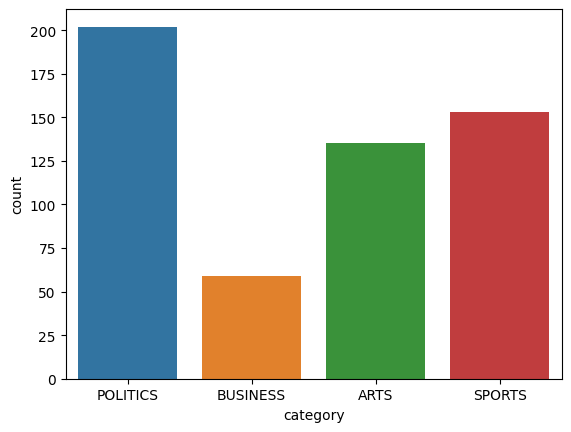

In [9]:
sns.countplot(data=df, x='category')
plt.show()

<h1 style="background-color:navy;">3) Data Preprocessing</h1>

##### Printing the text of each article to see what kind of cleaning process we need

In [10]:
for i, row in df.iterrows():
    pprint(row['title'])
    print(row['text'])

Streaming output truncated to the last 5000 lines.
Captain Olga Carmona, named player of the final after scoring the winning goal, reiterated the sentiment afterward.
"Of course, we have suffered, but now it is worth it. This is the only way it could have been," she said.
The context of that suffering is all the more evident now in the wake of Rubiales' kiss of Hermoso, which the 81 national players said was a sign of the challenging environment they have had to deal with for many years.
"The players have always deserved better, but there were too many working against them," journalist Olmeda explained. "This is a first step towards hope, but it cannot be the last."
Edited by James Thorogood
'Brazil: Lula adds Bolsonaro supporters to Cabinet 07.09.2023'
Brazilian President Luiz Inacio Lula da Silva on Wednesday announced a Cabinet reshuffle that will bring into his government two ministers who were once allied with his political rival and predecessor Jair Bolsonaro.
Andre Fufuca was na

### Function to clean text

In [11]:
def clean_text(text):
    # Remove non-alphanumeric characters and extra whitespaces
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

In [12]:
df['text'] = df['text'].apply(clean_text)

In [13]:
for i, row in df.iterrows():
    pprint(f"*** {row['title']} ****")
    print(row['text'])
    print('\n')

Streaming output truncated to the last 5000 lines.


("*** Air Guitar Championship won by Japan's Nagura for third time 26.08.2023 "
 '****')
Nanami Seven Seas Nagura has won the Air Guitar World Championships in Finland
This is Naguras third air guitar title
The Japanese performer is now the most decorated air guitar player in the 28 years the competition has been held organizers said
Second place went to Aapo the Angus Rautio from Finland The host nations competitor won the event the first five consecutive years it was held but Finland has never been able to claim the top spot since
Last years winner Kirill Guitarantula Blumenkrants now representing France but formerly a winner as a Russian competitor in 2015 as well finished third
A total of 18 people competed in the 2023 championship in Oulu
Air guitar refers to simulating the playing of a guitar without holding an instrument Competitors perform to music at the competition
The championship has been held each year since 1996  with t

### Stop words removal, tokenization and lemmatization

- All the text are in English, so we remove stop words like a, an The, I, we, and , in, at, etc. because they lack specific meaning and are in high frequency in the text. Here, we are doing classification of the news article, so these stop words might not be as important as they are in sentiment analysis task.
- Lemmatization involves reducing words to their base dictionary form, known as lemma. We are choosing this because it gives more meaning and we don't have large dataset(594 rows) to have computation expensive problem.
- Tokenization means creating tokens of words from a sentence, this is required for lemmatization

In [14]:
stop_words = set(stopwords.words('english'))

def preprocess_stop_words(text_list):
    res_list=[]
    for word in text_list:
        if word not in stop_words:
            res_list.append(word)

    return ' '.join(res_list)


In [15]:
df['processed_text'] = df['text'].str.split().apply(preprocess_stop_words)

In [16]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [17]:
df['processed_text'] = df['processed_text'].apply(lemmatize_text)

In [18]:
df.columns

Index(['url', 'category', 'title', 'text', 'processed_text'], dtype='object')

### Converting target categories to numeric

In [19]:
target_labels = {'POLITICS':0, 'BUSINESS':1, 'ARTS':2, 'SPORTS':3}
df['category'] = df['category'].replace(target_labels)

In [20]:
df.head()

,url,category,title,text,processed_text
0,https://www.dw.com/en/germany-undeterred-by-gl...,0,Germany undeterred by global turmoil — Scholz ...,In his New Years message German Chancellor Ola...,In New Years message German Chancellor Olaf Sc...
1,https://www.dw.com/en/taiwan-presidential-cand...,0,Taiwan: Presidential candidates debate in shad...,Taiwans presidential candidates argued over wa...,Taiwans presidential candidate argued way hand...
5,https://www.dw.com/en/whats-in-store-for-eu-so...,0,What's in store for EU-Southeast Asia ties in ...,European Parliament elections will be held in ...,European Parliament election held early June t...
7,https://www.dw.com/en/belgiums-ambitious-goals...,0,Belgium's ambitious goals for the EU Council P...,Asked what makes Belgium especially suited to ...,Asked make Belgium especially suited take EU C...
8,https://www.dw.com/en/berlin-police-primed-for...,0,Berlin police primed for 'tough action' on New...,German Interior Minister Nancy Faeser on Satur...,German Interior Minister Nancy Faeser Saturday...


<h1 style="background-color: navy;">4) Splitting the dataset into train, validation and test</h1>


In [21]:
X = df['text']
y = df['category']

# Split the dataset into full training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, shuffle=True)

# Split the full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, shuffle=True)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(351,)
(351,)
(88,)
(88,)
(110,)
(110,)


<h1 style="background-color: navy;">5) Text classification using pre-trained BERT</h1>

- BERT pre-trained uncased (bert-base-uncased), it typically refers to a specific variant of the BERT (Bidirectional Encoder Representations from Transformers) model that has been pre-trained on a large corpus of text and is case-insensitive.
- We are using base version and these are its specifications:
    - Number of Tokens: Around 110 million parameters.
    - Vocabulary Size: 30,000 tokens.
    - Model Size: 12 layers, 768 hidden units per layer, and 12 attention heads.
- As BERT is a State of the Art (sota) architecture for NLP tasks, we also use it for our news classification task.

### Load BERT tokenizer and model

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(y.to_list())))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize and pad the input sequences

In [26]:
X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

In [27]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='tf')
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='tf')


### Convert target labeles to tensors

In [28]:
y_train_tensors = tf.convert_to_tensor(y_train)
y_val_tensors = tf.convert_to_tensor(y_val)
y_test_tensors = tf.convert_to_tensor(y_test)

### Create tensorflow datasets

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_tensors))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val_tensors))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_tensors))

### Batch and shuffle the datasets

- Batch size = 32
- Shuffling 100 samples before create a batch

In [31]:
train_dataset = train_dataset.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

### Training the pretrained BERT model with our custom datasets

In [32]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
num_epochs = 5
model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/5
11/11 [==============================] - 678s 58s/step - loss: 1.1218 - accuracy: 0.5584 - val_loss: 0.6215 - val_accuracy: 0.8295
Epoch 2/5
11/11 [==============================] - 622s 57s/step - loss: 0.4285 - accuracy: 0.8946 - val_loss: 0.3872 - val_accuracy: 0.8750
Epoch 3/5
11/11 [==============================] - 582s 53s/step - loss: 0.2162 - accuracy: 0.9373 - val_loss: 0.2891 - val_accuracy: 0.8977
Epoch 4/5
11/11 [==============================] - 631s 58s/step - loss: 0.1147 - accuracy: 0.9715 - val_loss: 0.4763 - val_accuracy: 0.8750
Epoch 5/5
11/11 [==============================] - 579s 53s/step - loss: 0.0563 - accuracy: 0.9886 - val_loss: 0.2520 - val_accuracy: 0.9091


In [45]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109485316 (417.65 MB)
Trainable params: 109485316 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Function to evaluate performance of a model and append the metrics to a dataframe

In [67]:
def evaluate_metrics(perf_df, y_true, y_pred, algo):
  # Calculate accuracy, precision, and recall
  accuracy = balanced_accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  temp_df = pd.DataFrame({'algorithm':[algo],'balanced_accuracy':[accuracy], 'precision':[precision], 'recall':[recall]})
  metrics_df = pd.concat([perf_df, temp_df], ignore_index=True)
  return metrics_df

### Define a new dataframe to store all performance metrics of models

In [83]:
metrics_df = pd.DataFrame(columns=('algorithm', 'balanced_accuracy', 'precision', 'recall'))
metrics_df

,algorithm,balanced_accuracy,precision,recall


### Prediction on test data

In [84]:
# Perform prediction using the fitted model using softmax activation function because we have multi-class classification
outputs = model(test_encodings)
predictions = tf.nn.softmax(outputs.logits, axis=1) # gives 4 probabilites for 4 classes
# provide the prediction as actual target labels
y_pred = tf.argmax(predictions, axis=1).numpy()
metrics_df = evaluate_metrics(metrics_df, y_test, y_pred, 'pre-trained BERT (fine-tuned)')
metrics_df


,algorithm,balanced_accuracy,precision,recall
0,pre-trained BERT (fine-tuned),0.785518,0.853473,0.863636


<h1 style="background-color:navy;">6) Term Frequencey - Inverse Document Frequency with Support Vector Machine (TF-IDF with SVM)</h1>

- TF-IDF (Term Frequency-Inverse Document Frequency), it's a text vectorization technique widely used in natural language processing
- Term Frequency (TF): It measures how often a term appears in a document.It is calculated as the number of times a term occurs in a document divided by the total number of terms in that document.
- Inverse Document Frequency (IDF): It measures the importance of a term across a collection of documents. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term, plus one
- This technique is depended on frequency of words. And, certain category on news have certain words which are quite frequent so this one is well-suited for our news classification task.

### TF-IDF Vectorization

In [85]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [86]:
# Train SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_tfidf, y_train)
# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_tfidf)
metrics_df = evaluate_metrics(metrics_df, y_test, y_pred, 'TFIDF with SVC default')
metrics_df

,algorithm,balanced_accuracy,precision,recall
0,pre-trained BERT (fine-tuned),0.785518,0.853473,0.863636
1,TFIDF with SVC default,0.736134,0.881773,0.854545


### Cross validation of SVM classifier with some hyper-parameters for their optimization

In [64]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 50, 100],  # Regularization parameter valid for all kernel types
    'gamma': [0.1, 0.5, 1, 2, 5],           # this parameter is only valid for rbf kernel svc
    'degree':[2, 3, 4],                     # valid parameter for poly kernel only
    'kernel': ['rbf','linear','poly'],      # kernel types
}

# Create an SVM model
svm_model = SVC()

# Create the GridSearchCV object
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
grid_search.fit(X_train_tfidf, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


From above cross validation, we have kernel = 'rbf', so we only see the hyperparameter 'C' = 10 as the optimized hyperparameter.

In [87]:
# get best model from gridsearch cv
best_model = grid_search.best_estimator_
# Make predictions on the test set
y_pred = best_model.predict(X_test_tfidf)
metrics_df = evaluate_metrics(metrics_df, y_test, y_pred, 'TFIDF with SVC(rbf)')
metrics_df

,algorithm,balanced_accuracy,precision,recall
0,pre-trained BERT (fine-tuned),0.785518,0.853473,0.863636
1,TFIDF with SVC default,0.736134,0.881773,0.854545
2,TFIDF with SVC(rbf),0.813057,0.905171,0.890909


<h1 style="background-color:navy;">Conclusion and Recommendation</h2>

- From the above cells, we can observe that we trained our news articles on different models and set-ups to classify a news article into one of the four categories (Politics, Sports, Arts, Business).
- Among all models fine-tuned and trained,  it is observed that the best prediction model was hyperparameters-tuned Term-Frequency Inverse Document Frequency with balanced_accuracy of 0.81, precision of 0.91, and recall 0.89. As expected, it performed really well as mentioned earlier, news classification is quite influential with the frequency of certain type of words.
- Fine tuned BERT model performed better than unoptimized TFIDF with SVM as classifier but didn't outperform the hyperparameters tuned TFIDF SVC. This is because, our dataset is quite small and the training and validation set was also not quite big to train on. Moreover, we only used a standard batch size, learning rate and very less no of epochs. So our fine-tuned BERT model is no where near its optimum capability, which we can achieve by cross validation of parameters such as batch size, learning rate and epochs.
- So, the further recommendation for news classification would be to do cross validation of parameters in pre-trained BERT model. Also, we can experiment with our machine learning algorithms like Random Forest, XGBoost which are known for their great prediction capability.
- Moreover, experimentation with other pretrained models such as bert-large-uncased, bert-large-cased would also be recommended actions further.

# References

- https://huggingface.co/bert-base-uncased
- https://www.tensorflow.org/api_docs/python/tf
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html